# Experiments with SDSS Data

This notebook shows how to reproduce the experiments in *Approximate Inference for Constructing Astronomical Catalogs from Images* using the [Celeste.jl](https://github.com/jeff-regier/Celeste.jl) package and Julia 0.6.4. To install Celeste, run
```
Pkg.update()
Pkg.add("Celeste")
```

In [1]:
Pkg.status("Celeste")

 - Celeste                       0.4.0+             reproducibility (dirty)


In [1]:
import Celeste: AccuracyBenchmark, SDSSIO, Synthetic, ParallelRun
using DataFrames, CSV
import PyPlot

INFO: Recompiling stale cache file /Users/acm/.julia/lib/v0.6/Celeste.ji for module Celeste.
ERROR: LoadError: LoadError: ArgumentError: Module NearestNeighbors not found in current path.
Run `Pkg.add("NearestNeighbors")` to install the NearestNeighbors package.
Stacktrace:
 [1] _require(::Symbol) at ./loading.jl:428
 [2] require(::Symbol) at ./loading.jl:398
 [3] include_from_node1(::String) at ./loading.jl:569
 [4] include(::String) at ./sysimg.jl:14
 [5] include_from_node1(::String) at ./loading.jl:569
 [6] include(::String) at ./sysimg.jl:14
 [7] anonymous at ./<missing>:2
while loading /Users/acm/.julia/v0.6/Celeste/src/Coordinates.jl, in expression starting on line 7
while loading /Users/acm/.julia/v0.6/Celeste/src/Celeste.jl, in expression starting on line 18


LoadError: [91mFailed to precompile Celeste to /Users/acm/.julia/lib/v0.6/Celeste.ji.[39m

## 1. Load some catalogs

In [3]:
primary_catalog = AccuracyBenchmark.load_primary(AccuracyBenchmark.STRIPE82_RCF, AccuracyBenchmark.SDSS_DATA_DIR)
head(primary_catalog)

,objid,ra,dec,is_star,flux_r_nmgy,color_ug,color_gr,color_ri,color_iz,gal_frac_dev,gal_axis_ratio,gal_radius_px,gal_angle_deg
1,1237663784734490644,0.455258,0.611827,true,12.0878,3.11219,1.25308,0.833756,0.449864,0.0,0.999936,0.0245935,72.3498
2,1237663784734490645,0.457945,0.60102,false,42.4246,1.32123,0.702266,0.46665,0.0713212,0.0,0.600007,5.02739,54.279
3,1237663784734490646,0.452085,0.597542,false,10.7722,1.3876,1.62647,0.68046,0.512688,0.655229,0.644871,1.36462,134.109
4,1237663784734490668,0.468856,0.533093,true,379.548,1.08377,0.379158,0.118438,0.0499962,0.0,0.69987,0.0141502,105.359
5,1237663784734490670,0.471615,0.517553,true,90.514,1.20337,0.469821,0.167938,0.097679,0.9853,0.771631,0.0488277,105.466
6,1237663784734490672,0.481218,0.517017,true,227.672,1.23845,0.477644,0.162442,0.068806,0.503044,0.75223,0.0179534,105.48


In [4]:
coadd_catalog = AccuracyBenchmark.load_coadd_catalog(AccuracyBenchmark.COADD_CATALOG_FITS)

# filter the coadd catalog -- these columns can't be missing
no_na_cols = :flux_r_nmgy, :color_ug, :color_gr, :color_ri, :color_iz
for col in no_na_cols
    coadd_catalog = coadd_catalog[.!ismissing.(coadd_catalog[col]), :]
end

head(coadd_catalog)

,objid,ra,dec,is_star,flux_r_nmgy,color_ug,color_gr,color_ri,color_iz,gal_frac_dev,gal_axis_ratio,gal_radius_px,gal_angle_deg
1,8647474692482203784,0.536969,0.572232,false,4.20126,1.18763,0.664524,0.941524,-0.0294029,0.658111,0.204593,2.10751,5.16219
2,8647474692482203814,0.543336,0.460541,true,19.3121,2.29263,1.25516,0.825686,0.475343,missing,missing,missing,missing
3,8647474692482138371,0.452067,0.597554,false,13.5317,2.40159,1.45971,0.433763,0.481071,0.983442,0.622878,2.21404,133.298
4,8647474692482138403,0.461833,0.563745,false,1.89322,0.159879,1.63116,0.732745,0.575775,0.906633,0.0653559,0.205927,62.7757
5,8647474692482204160,0.515754,0.517092,true,1.71441,0.944377,0.34063,0.147833,0.0732357,missing,missing,missing,missing
6,8647474692482204190,0.520442,0.598824,true,4.15835,1.00537,0.292471,0.100794,0.0374307,missing,missing,missing,missing


## 2. Load various image sets

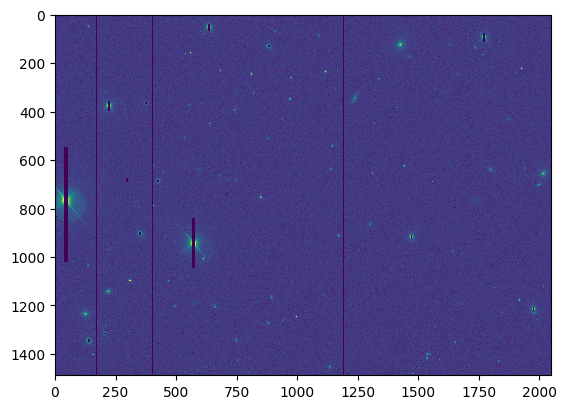

PyObject <matplotlib.image.AxesImage object at 0x7fb5b11977b8>

In [5]:
# load SDSS images
dataset = SDSSIO.SDSSDataSet(AccuracyBenchmark.SDSS_DATA_DIR)
sdss_images = SDSSIO.load_field_images(dataset, AccuracyBenchmark.STRIPE82_RCF);
plot_data = AccuracyBenchmark.plot_image(sdss_images[3]);
PyPlot.imshow(plot_data)

## 3. Run variational inference (VI) on the image set

The next block of code takes about 30 minutes single threaded. To enable more threads, before launching Jupyter, set two environment variables:
```
export OMP_NUM_THREADS=1
export JULIA_NUM_THREADS=4
```
The most optimized VI implementation is on the [kf/sparsefun5](https://github.com/jeff-regier/Celeste.jl/tree/kf/sparsefun5) branch -- not this one.

In [6]:
dummy_box = ParallelRun.BoundingBox(-1000.0, 1000.0, -1000.0, 1000.0)
sdss_results = ParallelRun.infer_box(sdss_images, dummy_box; method = :single_vi);

[1]<1> INFO: processing box -1000.0, 1000.0, -1000.0, 1000.0 with 4 threads
[1]<3> INFO: #3 at (0.44807477931741146, 0.6330991709052634): 22.489732637 secs
[1]<2> INFO: #2 at (0.44329635680621854, 0.46964106986349835): 22.519944228 secs
[1]<4> INFO: #4 at (0.4482822584625379, 0.425545129575396): 23.266592865 secs
[1]<2> INFO: #6 at (0.45255240408114783, 0.5301511401917836): 1.014169075 secs
[1]<1> INFO: #1 at (0.4426326409500359, 0.5787913361808047): 25.666932096 secs
[1]<3> INFO: #5 at (0.44860123139366154, 0.48024702728864027): 4.368736606 secs
[1]<1> INFO: #9 at (0.4572488069155581, 0.5073286880130589): 6.987534293 secs
[1]<1> INFO: #11 at (0.45968552777371546, 0.5345472515295158): 0.966884788 secs
[1]<4> INFO: #7 at (0.4531788931183803, 0.6049441669619277): 10.362392046 secs
[1]<4> INFO: #13 at (0.46067920738107865, 0.4696704935511662): 1.862759574 secs
[1]<1> INFO: #12 at (0.46013692572005793, 0.47189458741666146): 2.421872938 secs
[1]<4> INFO: #14 at (0.46121236376543256, 0.60457

## 4. Run MCMC on the image set

MCMC is parallelized differently (using `pmap`), which requires running an exterior script to schedule a set of jobs.  For the MCMC SDSS Stripe2 experiment script to run, we need a few files to be saved (based on the synthetic catalog and the image pixels generated above).  The following commands will reproduce our experiments

1. Create ground truth files (repeats code above)
 ```
$ cd Celeste.jl/benchmark/accuracy
$ julia write_ground_truth_catalog_csv.jl coadd
$ julia sdss_rcf_to_csv.jl  # DEFAULTS to S82 Field
 ``` 
  which will create a file `sdss_4263_5_119_prediction_<hash>.csv` in the directory `Celeste.jl/benchmark/accuracy/output`. 

2. Run the AIS-MCMC code on each source
  ```
$ cd Celeste.jl/experiments/mcmc_scripts
$ ./run_s82_shards.sh
  ```
  which will schedule jobs for each set of sources and store samples in directory `ais-output-s82`.
 
3. Score results  
```
julia score_mcmc_results.jl --ais-output ais-output-synthetic --output-dir synthetic-results \
  --truth-csv ~/Proj/Celeste.jl/benchmark/accuracy/output/coadd_for_4263_5_119_<hash>.csv \
  --vb-csv ~/Proj/Celeste.jl/benchmark/accuracy/output/sdss_4263_5_119_predictions_<hash>.csv \
  --photo-csv ~/Proj/Celeste.jl/benchmark/accuracy/output/sdss_4263_5_119_primary_<hash>.csv
```
  which saves a bunch of `csv` files to `experiments/mcmc_scripts/s82-results/` needed to reproduce plots (including the prediction score and uncertainty score dataframes that mirror the results below). 

## 5. Score predictions

In [7]:
celeste_catalog = AccuracyBenchmark.celeste_to_df(sdss_results)
prediction_dfs = [primary_catalog, celeste_catalog,]
scores = AccuracyBenchmark.score_predictions(coadd_catalog, prediction_dfs)

,N,first,second,diff,diff_sd,field
1,59,0.0169492,0.0338983,-0.0169492,0.0169492,missed_stars
2,247,0.0283401,0.0242915,0.00404858,0.0119466,missed_galaxies
3,306,0.266245,0.274899,-0.00865445,0.00826177,position
4,306,0.181913,0.129396,0.0525175,0.013055,flux_r_mag
5,306,0.768396,0.645925,0.122471,0.0482431,flux_r_nmgy
6,75,16.1186,11.2796,4.83897,1.64226,gal_angle_deg
7,152,0.231962,0.139562,0.0924005,0.0260341,gal_frac_dev
8,152,0.192954,0.128236,0.0647183,0.0108201,gal_axis_ratio
9,152,1.31824,0.52948,0.788759,0.427942,gal_radius_px
10,293,1.01626,0.588286,0.427979,0.0568488,color_ug


## 6. Score uncertainty

In [8]:
uncertainty_df = AccuracyBenchmark.get_uncertainty_df(coadd_catalog, celeste_catalog)
scores = AccuracyBenchmark.score_uncertainty(uncertainty_df)

,field,within_half_sd,within_1_sd,within_2_sd,within_3_sd
1,log_flux_r_nmgy,0.0921409,0.200542,0.395664,0.588076
2,color_ug,0.227642,0.425474,0.715447,0.872629
3,color_gr,0.235772,0.490515,0.758808,0.899729
4,color_ri,0.227642,0.409214,0.753388,0.867209
5,color_iz,0.284553,0.525745,0.794038,0.924119


In [2]:
scores_mc = CSV.read("mcmc_scripts/s82-results/uscore_mc.csv")

LoadError: [91mArgumentError: Module CSV not found in current path.
Run `Pkg.add("CSV")` to install the CSV package.[39m